In [1]:
import yfinance as yf
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import shutil

In [2]:
TICKER = "NVDA"
historic_price = yf.download(TICKER)
prices = historic_price['Adj Close']

[*********************100%%**********************]  1 of 1 completed


Simple moving average function for feature extraction. Takes in the length of the moving average

In [3]:
MAX_HOLDING = 100

In [4]:
def get_sma(prices, MA):
    sma = []
    for pos1 in range(0, len(prices) - MA):
        sum = 0
        for change in range(MA, 0, -1):
            sum += prices.iloc[pos1 + change]
        sma.append(sum / MA)
    return sma

Standard deviation function for feature extraction. Takes in how long back to look to determine the standard deviation of a given price

In [5]:
def get_sd(prices, time):
    sd = []
    for pos1 in range(0, len(prices) - time):
        sum = 0
        for change in range(time, 0, -1):
            sum += prices.iloc[pos1 + change]
        mean = sum / time
        summa = 0
        for change in range(time, 0, -1):
            summa += (prices.iloc[pos1 + change] - mean) ** 2
        sd.append(math.sqrt(summa / time))
    return sd

Visit https://www.desmos.com/calculator/saxa0jcqds to see how time affects price with each function

In [6]:
time_effect1 = lambda L, x: 1-(x/L)
time_effect2 = lambda L, x: L/(x+L)
time_effect3 = lambda L, x: (-1/(L**2))(x**2)+1
time_effect3 = lambda L, x: -1/((x-L)**2)

In [7]:
answer = []
for pos1 in range(len(prices) - MAX_HOLDING):
    ans = 0
    for pos2 in range(1, MAX_HOLDING):
        ans += (prices.iloc[pos1 + pos2] - prices.iloc[pos1]) * time_effect1(MAX_HOLDING, pos2)
    answer.append(ans)

dp_factors = [answer[0]]
for pos in range(1, len(answer)):
    dp_factors.append(max(abs(answer[pos]), abs(dp_factors[-1])))
    answer[pos] /= dp_factors[pos]
answer[0] = 1

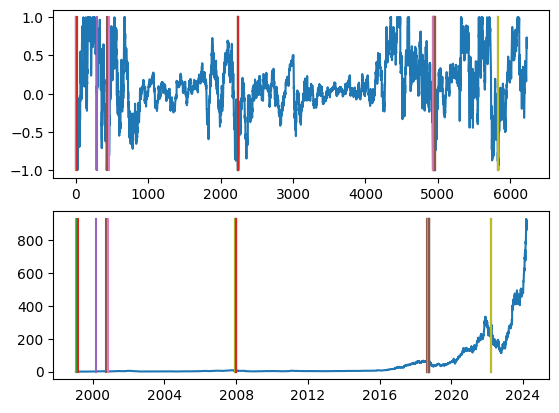

In [8]:
figure, axis = plt.subplots(2)
axis[0].plot(answer)
axis[1].plot(prices)
for pos in range(len(answer)):
    if answer[pos] < -0.99:
        axis[0].plot([pos, pos], [-1, 1])
        axis[1].plot([prices.keys()[pos], prices.keys()[pos]], [0, max(prices)])
plt.show()

In [9]:
sma10 = get_sma(prices, 10)
sma30 = get_sma(prices, 20)
sma50 = get_sma(prices, 50)
sma100 = get_sma(prices, 100)
sd10 = get_sd(prices, 10)
sd30 = get_sd(prices, 20)
sd50 = get_sd(prices, 50)
sd100 = get_sd(prices, 100)

LONGEST_SMA = 100
if MAX_HOLDING < LONGEST_SMA:
    answer = answer[LONGEST_SMA - MAX_HOLDING:]

x = []
y = []
for pos in range(0, len(prices) - LONGEST_SMA):
    temp = [0] * 200
    x.append([sma10[pos], sma30[pos], sma50[pos], sma100[pos], sd10[pos], sd30[pos], sd50[pos], sd100[pos]])
    ans = (answer[pos] + 1) / 2
    y.append(ans)
x = np.array(x)
y = np.array(y)
prices = prices[MAX_HOLDING - LONGEST_SMA:len(prices) - MAX_HOLDING]
print(len(x), len(y))

6230 6230


In [23]:
TRAIN_AMNT = 0.9
x_train, x_test, y_train, y_test = train_test_split(x[:round(len(x)*TRAIN_AMNT)], y[:round(len(y)*TRAIN_AMNT)], test_size=0.2)

Training and testing dataset includes everything until the last 20% history of the stock. This is done to simulate the neural net never having seen the last 10% of prices so we can test its validity.

In [24]:
def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(8,), name='layers_flatten'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1),
  ])

In [25]:
model = create_model()
model.compile(optimizer='adam',
              loss='mean_absolute_error',)

In [26]:
model.fit(x=x_train, 
          y=y_train, 
          epochs=50, 
          validation_data=(x_test, y_test), 
)

Epoch 1/50
141/141 [==============================] - 2s 5ms/step - loss: 0.2170 - val_loss: 0.0900
Epoch 2/50
141/141 [==============================] - 1s 4ms/step - loss: 0.0811 - val_loss: 0.0724
Epoch 3/50
141/141 [==============================] - 1s 4ms/step - loss: 0.0754 - val_loss: 0.0595
Epoch 4/50
141/141 [==============================] - 1s 4ms/step - loss: 0.0652 - val_loss: 0.0679
Epoch 5/50
141/141 [==============================] - 1s 4ms/step - loss: 0.0598 - val_loss: 0.0643
Epoch 6/50
141/141 [==============================] - 1s 4ms/step - loss: 0.0592 - val_loss: 0.0656
Epoch 7/50
141/141 [==============================] - 1s 4ms/step - loss: 0.0588 - val_loss: 0.0587
Epoch 8/50
141/141 [==============================] - 1s 4ms/step - loss: 0.0561 - val_loss: 0.0548
Epoch 9/50
141/141 [==============================] - 1s 4ms/step - loss: 0.0544 - val_loss: 0.0548
Epoch 10/50
141/141 [==============================] - 1s 4ms/step - loss: 0.0546 - val_loss: 0.0579

In [27]:
predictions = model.predict(x[round(len(x)*TRAIN_AMNT):])
dates = prices.keys()

20/20 [==============================] - 0s 2ms/step


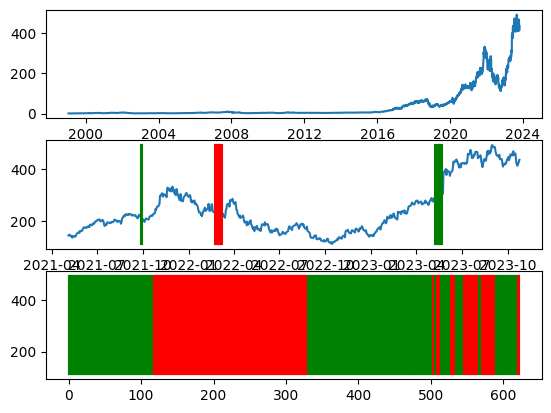

In [28]:
CONFIDENT_X = 10
figure, axis = plt.subplots(3)
axis[0].plot(prices)
axis[1].plot(prices[int(TRAIN_AMNT * len(prices)):])

bests = [(float(predictions[x][0]), dates[int(TRAIN_AMNT * len(prices))]) for x in range(CONFIDENT_X)]
worsts = [(float(predictions[x][0]), dates[int(TRAIN_AMNT * len(prices))]) for x in range(CONFIDENT_X)]

for pred_pos in range(len(predictions[CONFIDENT_X:])):
    val = predictions[CONFIDENT_X:][pred_pos]
    min_bests = 100
    max_worsts = -100        
    for pos in range(CONFIDENT_X):
        if bests[pos][0] < min_bests:
            min_pos = pos
            min_bests = bests[pos][0]
        if worsts[pos][0] > max_worsts:
            max_pos = pos
            max_worsts = worsts[pos][0]
    
    if float(val[0]) > min_bests:
        bests.pop(min_pos)
        bests.append((float(val[0]), dates[int(TRAIN_AMNT * len(prices)) + pred_pos]))
    if float(val[0]) < max_worsts:
        worsts.pop(max_pos)
        worsts.append((float(val[0]), dates[int(TRAIN_AMNT * len(prices)) + pred_pos]))
min_y = min(prices[int(TRAIN_AMNT * len(prices)):])
max_y = max(prices[int(TRAIN_AMNT * len(prices)):])
avg = sum(predictions) / len(predictions)
for pos in range(CONFIDENT_X):
    axis[1].plot([bests[pos][1], bests[pos][1]], [min_y, max_y], 'g')
    axis[1].plot([worsts[pos][1], worsts[pos][1]], [min_y, max_y], 'r')
for pos in range(len(predictions)):
    if predictions[pos][0] > avg:
        axis[2].plot([pos, pos], [min_y, max_y], 'g')
    else:
        axis[2].plot([pos, pos], [min_y, max_y], 'r')
plt.show()

In [22]:
path = 'Models/' + TICKER + '/'
if not os.path.exists(path):
    os.makedirs(path)
else:
    shutil.rmtree(path)
    os.makedirs(path)
model.save(path)
model.save_weights(path)

INFO:tensorflow:Assets written to: Models/NVDA/assets


INFO:tensorflow:Assets written to: Models/NVDA/assets
